# Python implementation of the Max Unmix method for coercivity spectra analysis

This notebook illustrates the `rockmagpy` implementation of the MAX UnMix algorithm developed for unmixing magnetic coercivity spectra. MAX UnMix was originally written in R, is currently available within a Shiny app (https://shinyapps.carleton.edu/max-unmix/), and is documented in the paper:
> Maxbauer, D. P., Feinberg, J. M., & Fox, D. L. (2016). MAX UnMix: A web application for unmixing magnetic coercivity distributions. Computers & Geosciences, 95, 140–145. https://doi.org/10.1016/j.cageo.2016.07.009

Here, we start by using the example data file used in MaxUnmix and then continue to illustrate how the Python implementation enables batch analysis.

## Import scientific python libraries

Run the cell below to import the functions needed for the notebook.

In [1]:
import pmagpy.rockmag as rmag
import pmagpy.ipmag as ipmag

import pmagpy.contribution_builder as cb
import pandas as pd
import matplotlib.pyplot as plt 

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## MaxUnmix example
 
 Here we import the data that were published with MaxUnmix as an example file.

In [2]:
MaxUnmix_data = pd.read_csv('../example_data/backfield_unmixing/MaxUnmix_example.csv')
MaxUnmix_data['B'] = -MaxUnmix_data['B']/1000
MaxUnmix_data.head()

,B,M
0,-0.00146,0.000007
1,-0.00224,0.000007
2,-0.00305,0.000007
3,-0.00389,0.000007
4,-0.00477,0.000007


### backfield processing

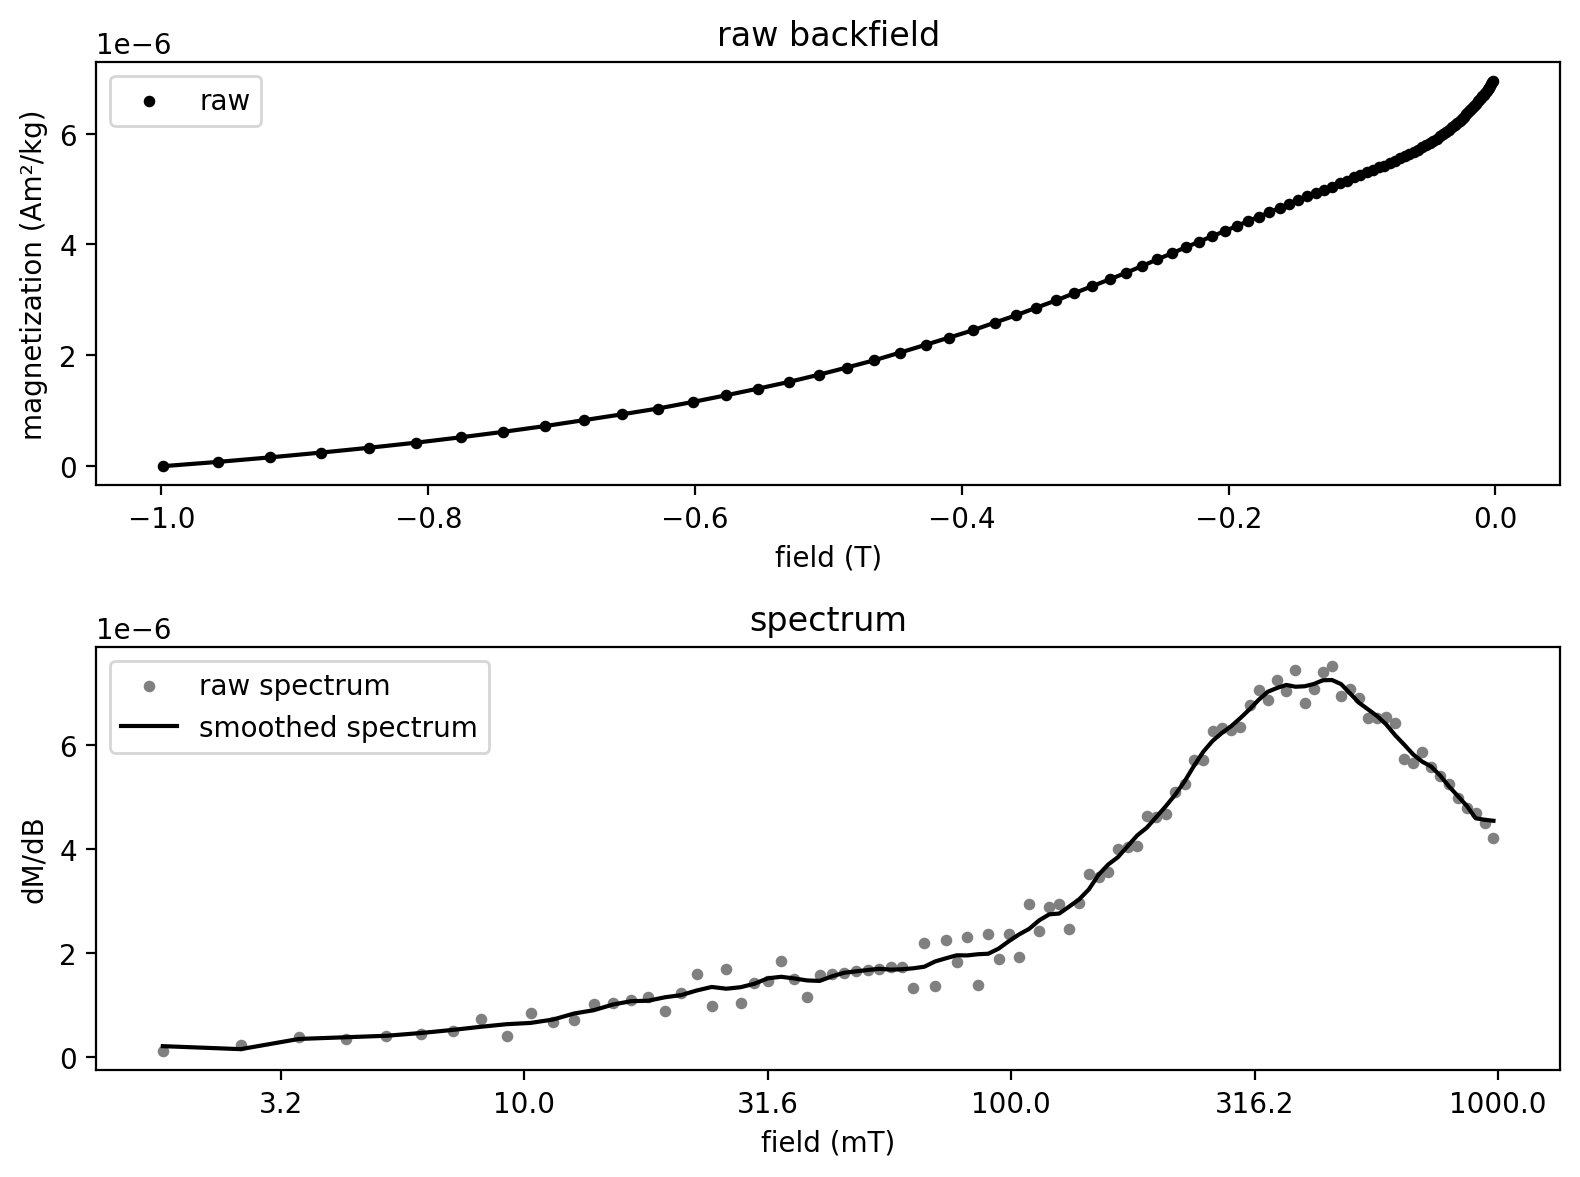

In [3]:
MaxUnmix_experiment, Bcr = rmag.backfield_data_processing(MaxUnmix_data, 
                                                          field='B', 
                                                          magnetization='M', 
                                                          smooth_frac=0.075)

fig, axs = rmag.plot_backfield_data(MaxUnmix_experiment, 
                                    field='B', magnetization='M', figsize=(8, 6), 
                                    plot_processed=False, plot_spectrum=True, return_figure=True)

### interactive fitting

An important aspect of the MaxUnmix process is for the user to make an initial guess for the parameters associated with the coercivity spectra that can then be optimized to fit the spectra. In the code cells below, the user can choose parameters that are then optimized by the code to become fits. An advantage to the approach implemented in `rockmagpy`, is that optimization occurs immediately with the provided guess. *Note that this optimization may make it so that changes to the initial guess do not result in changes to the fit particularly for one component.*

The user can specify the number of components to fit. We will start with 1 component and then do 2 components. 

#### 1 component

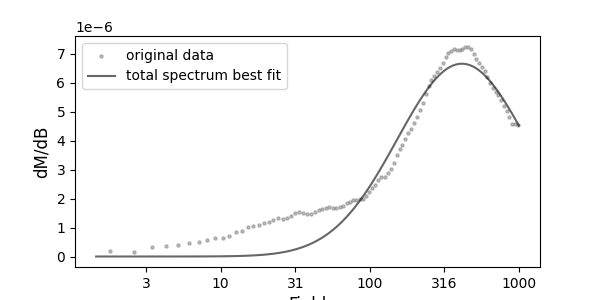

In [4]:
%matplotlib widget
one_fit = rmag.interactive_backfield_fit(MaxUnmix_experiment['smoothed_log_dc_field'], 
                               MaxUnmix_experiment['smoothed_magn_mass_shift'], 
                               n_components=1, figsize=(6, 3), skewed=False)

In [5]:
one_fit

,amplitude,center,sigma,gamma
0,1.0,414.448216,2.719811,0.0


#### 2 components

This example is not well-fit by one component — let's try two components.

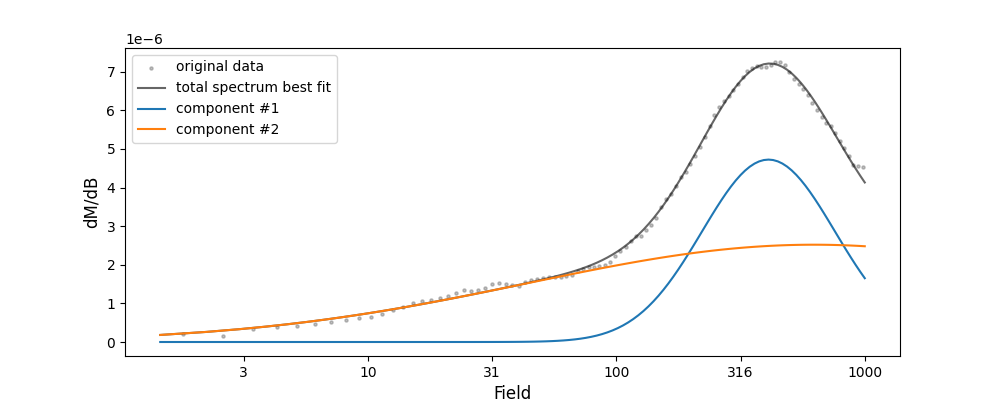

In [20]:
%matplotlib widget
two_fits = rmag.interactive_backfield_fit(MaxUnmix_experiment['smoothed_log_dc_field'], 
                               MaxUnmix_experiment['smoothed_magn_mass_shift'], 
                               n_components=2, figsize=(10, 4), skewed=False,)

In [21]:
two_fits

,amplitude,center,sigma,gamma
0,0.788587,440.172364,2.147026,0.0
1,0.276556,45.016203,3.460881,0.0


In [22]:
plt.close('all')
%matplotlib inline

### MaxUnmix error estimate

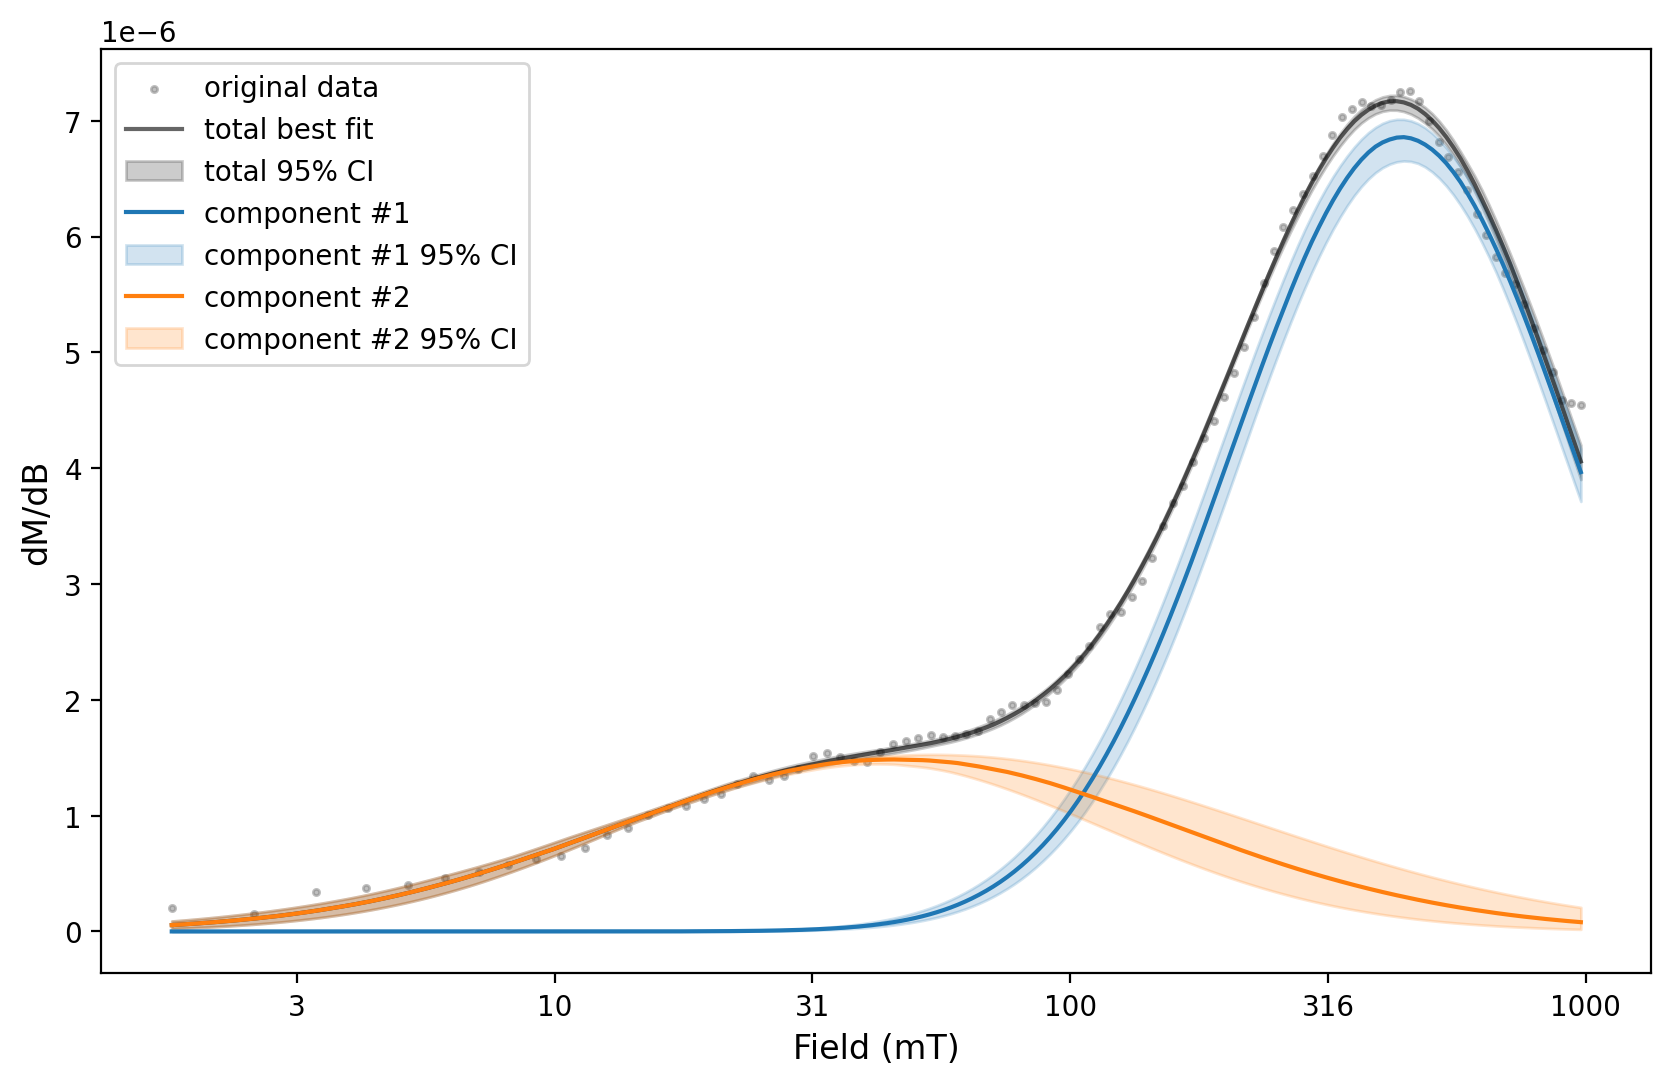

In [23]:
%matplotlib inline
MaxUnmix_ax, MaxUnmix_params = rmag.backfield_MaxUnmix(MaxUnmix_experiment['smoothed_log_dc_field'], 
                                                            MaxUnmix_experiment['smoothed_magn_mass_shift'], 
                                                            n_comps=2, parameters=two_fits, n_resample=100, skewed=False,)

In [10]:
MaxUnmix_params

{'g1_amplitude': 0.438610034889383,
 'g1_center': 409.3276917009343,
 'g1_sigma': 1.8505663766428904,
 'g1_gamma': 0.0,
 'g1_amplitude_std': 0.02899228873768302,
 'g1_center_std': 1.0073924204404414,
 'g1_sigma_std': 1.011495699348531,
 'g1_gamma_std': 0.0,
 'g2_amplitude': 0.9932587691586278,
 'g2_center': 610.2327376756963,
 'g2_sigma': 13.858860446013104,
 'g2_gamma': 0.0,
 'g2_amplitude_std': 0.06707309788657377,
 'g2_center_std': 1.2717878599775736,
 'g2_sigma_std': 1.1344347277351459,
 'g2_gamma_std': 0.0}

## Batch processing

If a suite of specimens has similar components (both in terms of number of components and their mean/dispersion) than the initial fit parameters for one specimen can be used in the analysis of them all. In this example, we apply such a batch processing approach to coercivity spectra obtained from hematite-bearing siltstones of the Freda Formation (that have both a detrital hematite and pigmentary hematite component).

The data are from:
> Swanson-Hysell, N. L., Fairchild, L. M., & Slotznick, S. P. (2019). Primary and secondary red bed magnetization constrained by fluvial intraclasts. Journal of Geophysical Research: Solid Earth, 124. https://doi.org/10.1029/2018JB017067
MagIC ID: 20387

We can download the data and isolate the measurement table.

In [11]:
dir_path = '../example_data/SwansonHysell2019'

MagIC_id = '20387'
share_key = '2deccada-115d-495c-964f-52f13f9786b2'

result, magic_file = ipmag.download_magic_from_id(MagIC_id, share_key=share_key, directory=dir_path)
ipmag.unpack_magic(magic_file, dir_path, print_progress=False)

Download successful. File saved to: ../example_data/SwansonHysell2019/magic_contribution_20387.txt
1  records written to file  /home/jupyter-polarwander/rockmag_notebooks/PmagPy-RockmagPy-notebooks-a26a094/example_data/SwansonHysell2019/contribution.txt
1  records written to file  /home/jupyter-polarwander/rockmag_notebooks/PmagPy-RockmagPy-notebooks-a26a094/example_data/SwansonHysell2019/locations.txt
8  records written to file  /home/jupyter-polarwander/rockmag_notebooks/PmagPy-RockmagPy-notebooks-a26a094/example_data/SwansonHysell2019/sites.txt
74  records written to file  /home/jupyter-polarwander/rockmag_notebooks/PmagPy-RockmagPy-notebooks-a26a094/example_data/SwansonHysell2019/samples.txt
486  records written to file  /home/jupyter-polarwander/rockmag_notebooks/PmagPy-RockmagPy-notebooks-a26a094/example_data/SwansonHysell2019/specimens.txt
20944  records written to file  /home/jupyter-polarwander/rockmag_notebooks/PmagPy-RockmagPy-notebooks-a26a094/example_data/SwansonHysell2019

True

In [12]:
# get the contribution object
contribution = cb.Contribution(dir_path)
# get the measurements table
measurements = contribution.tables['measurements'].df
measurements = measurements.dropna(axis=1, how='all')
specimens = contribution.tables['specimens'].df

-I- Using online data model
-I- Getting method codes from earthref.org
-I- Importing controlled vocabularies from https://earthref.org


We can then filter to isolate the backfield experiments with their `'LP-BCR-BF'` method code.

In [13]:
measurements_backfield = measurements[(measurements['method_codes'] == 'LP-BCR-BF')]
backfield_experiments = measurements_backfield['experiment'].unique()
backfield_experiments

array(['IRM-VSM2-LP-BCR-BF-198106', 'IRM-VSM2-LP-BCR-BF-198107',
       'IRM-VSM2-LP-BCR-BF-198767', 'IRM-VSM2-LP-BCR-BF-198727',
       'IRM-VSM2-LP-BCR-BF-198728', 'IRM-VSM2-LP-BCR-BF-198729',
       'IRM-VSM2-LP-BCR-BF-198737', 'IRM-VSM2-LP-BCR-BF-198756',
       'IRM-VSM2-LP-BCR-BF-198761', 'IRM-VSM2-LP-BCR-BF-198762',
       'IRM-VSM2-LP-BCR-BF-198763', 'IRM-VSM2-LP-BCR-BF-198768',
       'IRM-VSM2-LP-BCR-BF-198073', 'IRM-VSM2-LP-BCR-BF-198074',
       'IRM-VSM2-LP-BCR-BF-198193', 'IRM-VSM2-LP-BCR-BF-198199'],
      dtype=object)

Let's look at the first backfield experiment.

In [14]:
backfield_experiment_1 = measurements_backfield[measurements_backfield['experiment'] == backfield_experiments[0]]
backfield_experiment_1.head()

,citations,dir_csd,dir_dec,dir_inc,experiment,instrument_codes,magn_mass,magn_moment,magn_r2_det,magn_x_sigma,magn_y_sigma,magn_z_sigma,meas_field_ac,meas_field_dc,meas_freq,meas_n_orient,meas_temp,measurement,method_codes,quality,sequence,software_packages,specimen,standard,susc_chi_mass,susc_chi_qdr_mass,timestamp,treat_ac_field,treat_dc_field,treat_dc_field_phi,treat_dc_field_theta,treat_step_num,treat_temp
measurement name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BRIC-20cIRM-VSM2-LP-BCR-BF-1981061,This study,NaN,NaN,NaN,IRM-VSM2-LP-BCR-BF-198106,IRM-VSM2,0.007466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRIC-20cIRM-VSM2-LP-BCR-BF-1981061,LP-BCR-BF,g,7426,None,BRIC-20c,300,NaN,NaN,2018-11-13T15:48:00.000-06:00,NaN,-0.000003,NaN,NaN,NaN,NaN
BRIC-20cIRM-VSM2-LP-BCR-BF-1981062,This study,NaN,NaN,NaN,IRM-VSM2-LP-BCR-BF-198106,IRM-VSM2,0.007439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRIC-20cIRM-VSM2-LP-BCR-BF-1981062,LP-BCR-BF,g,7427,None,BRIC-20c,300,NaN,NaN,2018-11-13T15:48:00.000-06:00,NaN,-0.000251,NaN,NaN,NaN,NaN
BRIC-20cIRM-VSM2-LP-BCR-BF-1981063,This study,NaN,NaN,NaN,IRM-VSM2-LP-BCR-BF-198106,IRM-VSM2,0.007425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRIC-20cIRM-VSM2-LP-BCR-BF-1981063,LP-BCR-BF,g,7428,None,BRIC-20c,300,NaN,NaN,2018-11-13T15:48:00.000-06:00,NaN,-0.000516,NaN,NaN,NaN,NaN
BRIC-20cIRM-VSM2-LP-BCR-BF-1981064,This study,NaN,NaN,NaN,IRM-VSM2-LP-BCR-BF-198106,IRM-VSM2,0.007415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRIC-20cIRM-VSM2-LP-BCR-BF-1981064,LP-BCR-BF,g,7429,None,BRIC-20c,300,NaN,NaN,2018-11-13T15:48:00.000-06:00,NaN,-0.000799,NaN,NaN,NaN,NaN
BRIC-20cIRM-VSM2-LP-BCR-BF-1981065,This study,NaN,NaN,NaN,IRM-VSM2-LP-BCR-BF-198106,IRM-VSM2,0.007404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRIC-20cIRM-VSM2-LP-BCR-BF-1981065,LP-BCR-BF,g,743,None,BRIC-20c,300,NaN,NaN,2018-11-13T15:48:00.000-06:00,NaN,-0.001101,NaN,NaN,NaN,NaN


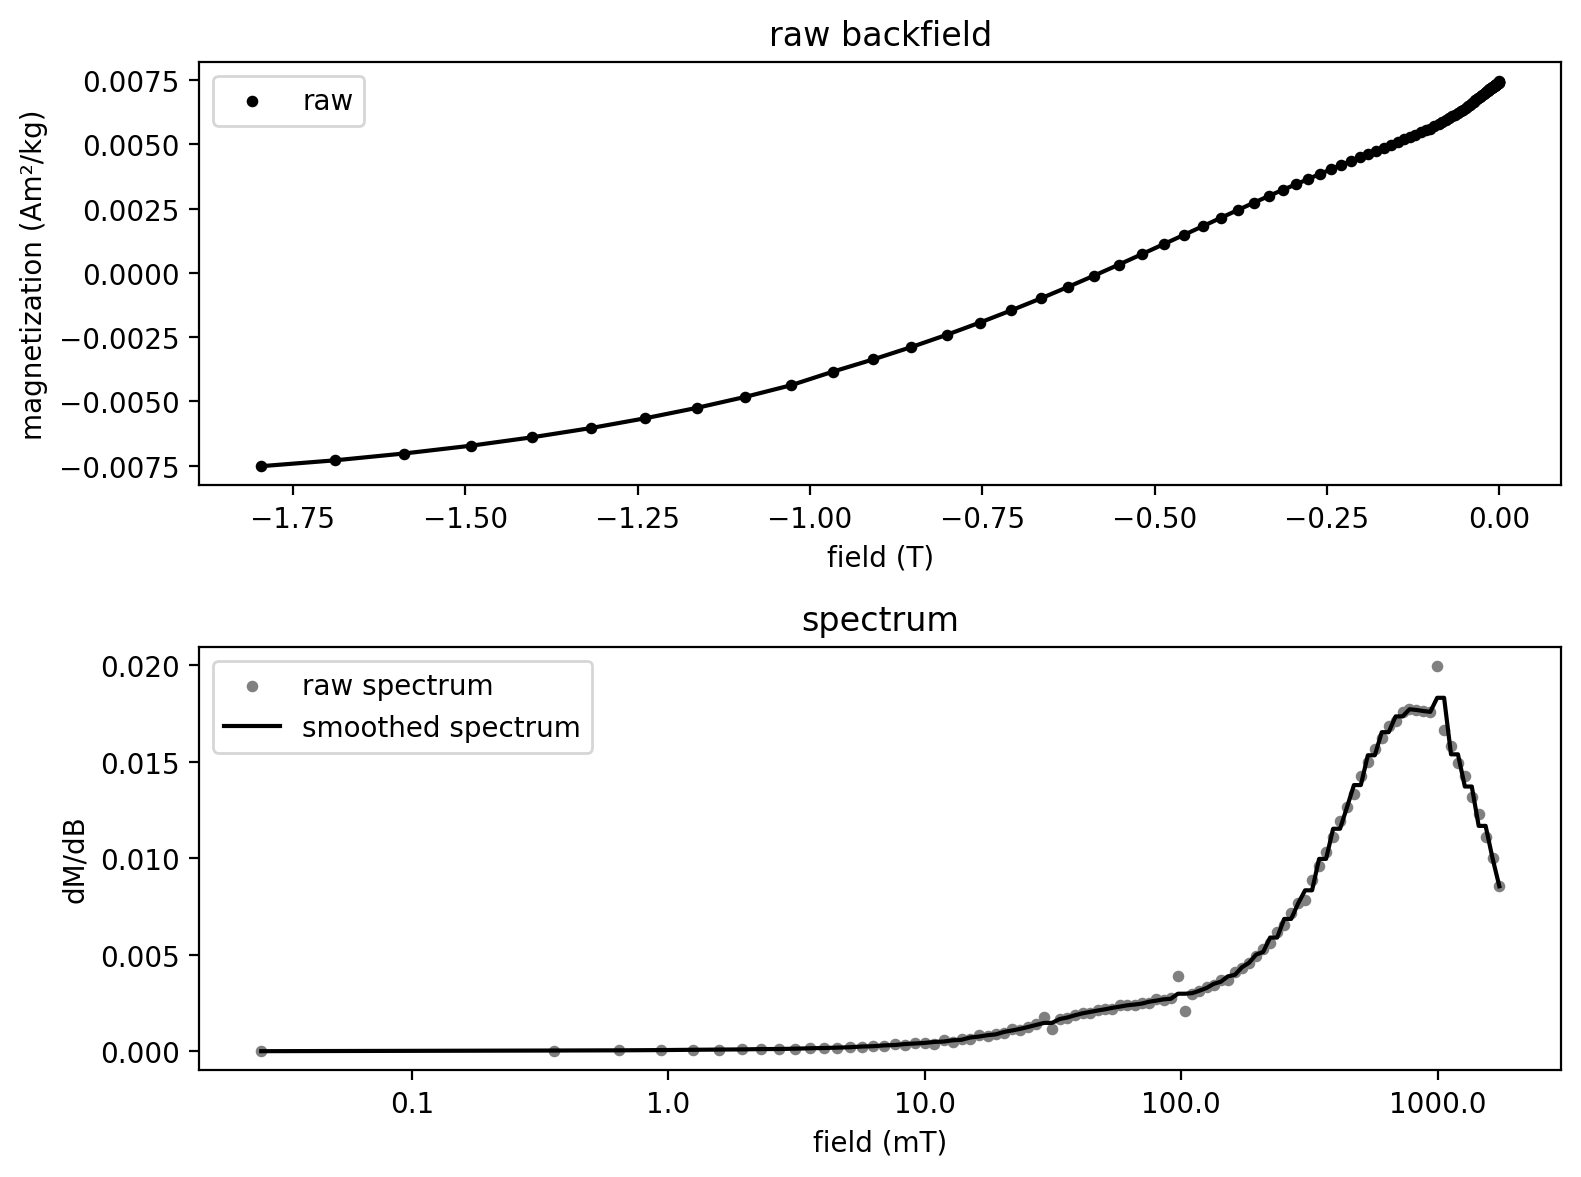

In [15]:
experiment_1, Bcr = rmag.backfield_data_processing(backfield_experiment_1, 
                                                          field='treat_dc_field', magnetization='magn_mass', 
                                                          smooth_frac=0.05)

fig, axs = rmag.plot_backfield_data(experiment_1, 
                                    field='treat_dc_field', magnetization='magn_mass', figsize=(8, 6), 
                                    plot_processed=False, plot_spectrum=True, return_figure=True)

Two components can be fit to the first spectra.

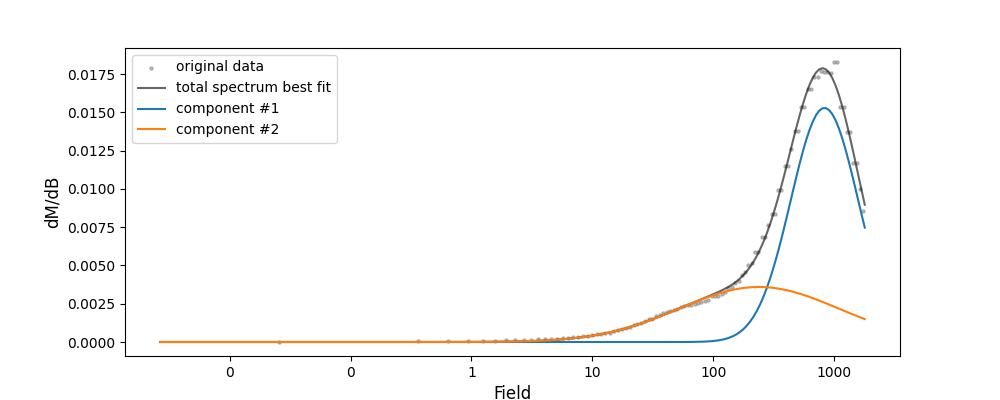

In [16]:
%matplotlib widget
two_fits = rmag.interactive_backfield_fit(experiment_1['smoothed_log_dc_field'], 
                               experiment_1['smoothed_magn_mass_shift'], 
                               n_components=2, figsize=(10, 4), skewed=False,)

The parameters resulting from this fit can then be used for the MaxUnmix error analysis.

In [17]:
plt.close('all')

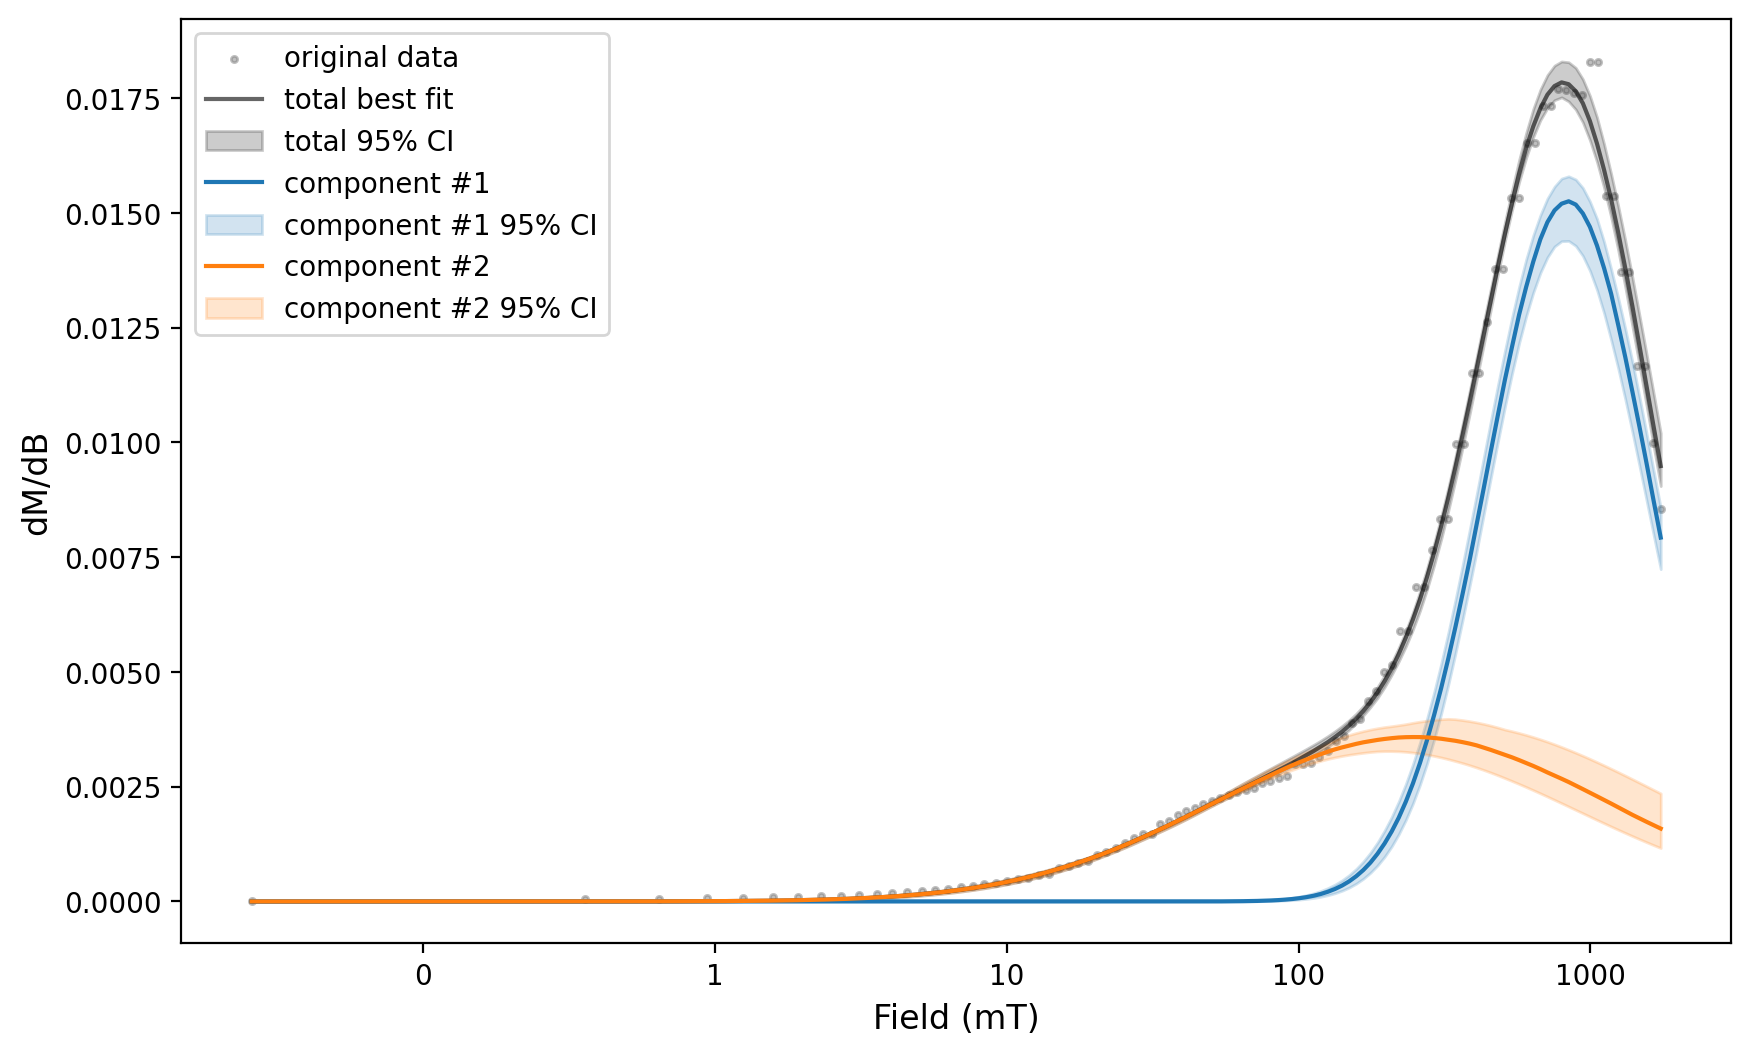

In [18]:
%matplotlib inline
experiment_1_ax, experiment_1_params = rmag.backfield_MaxUnmix(experiment_1['smoothed_log_dc_field'], 
                                                            experiment_1['smoothed_magn_mass_shift'], 
                                                            n_comps=2, parameters=two_fits, n_resample=100, skewed=False,)

We can then use the same fit parameters applied to this spectra for the error analysis of a number of spectra by looping through the backfield experiments. 

['BRIC-20c']


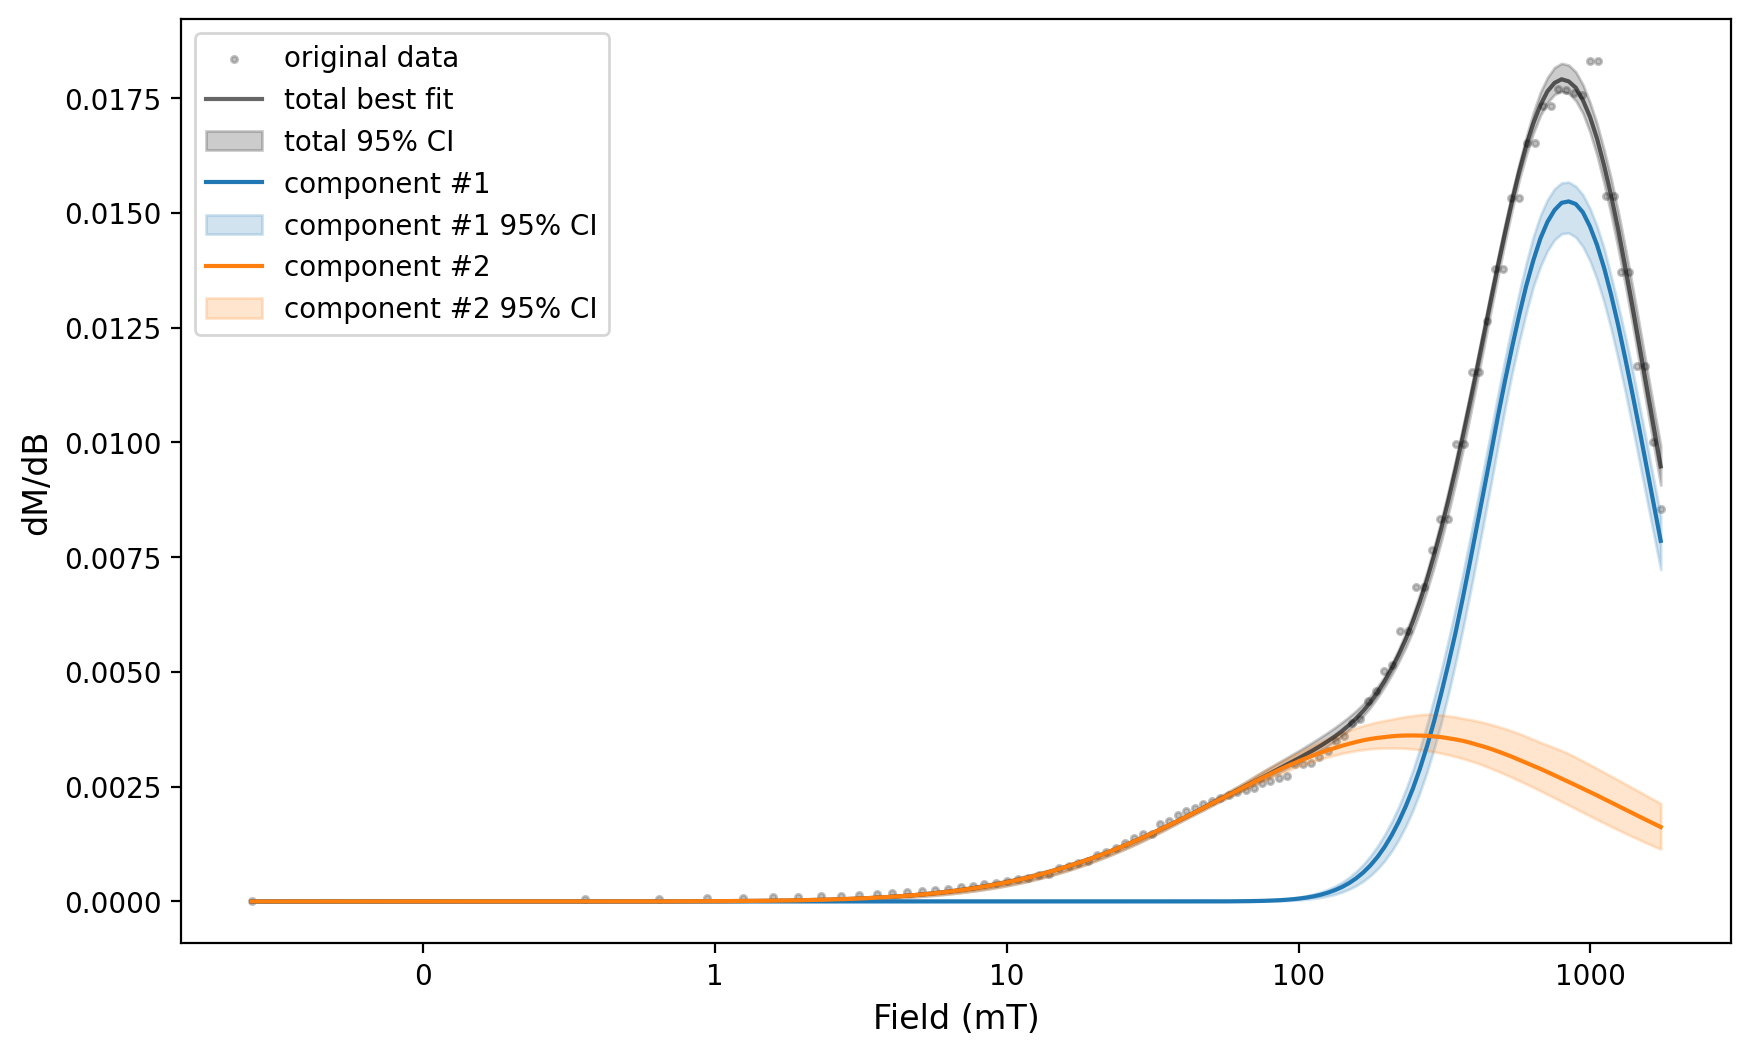

['BRIC-20e']


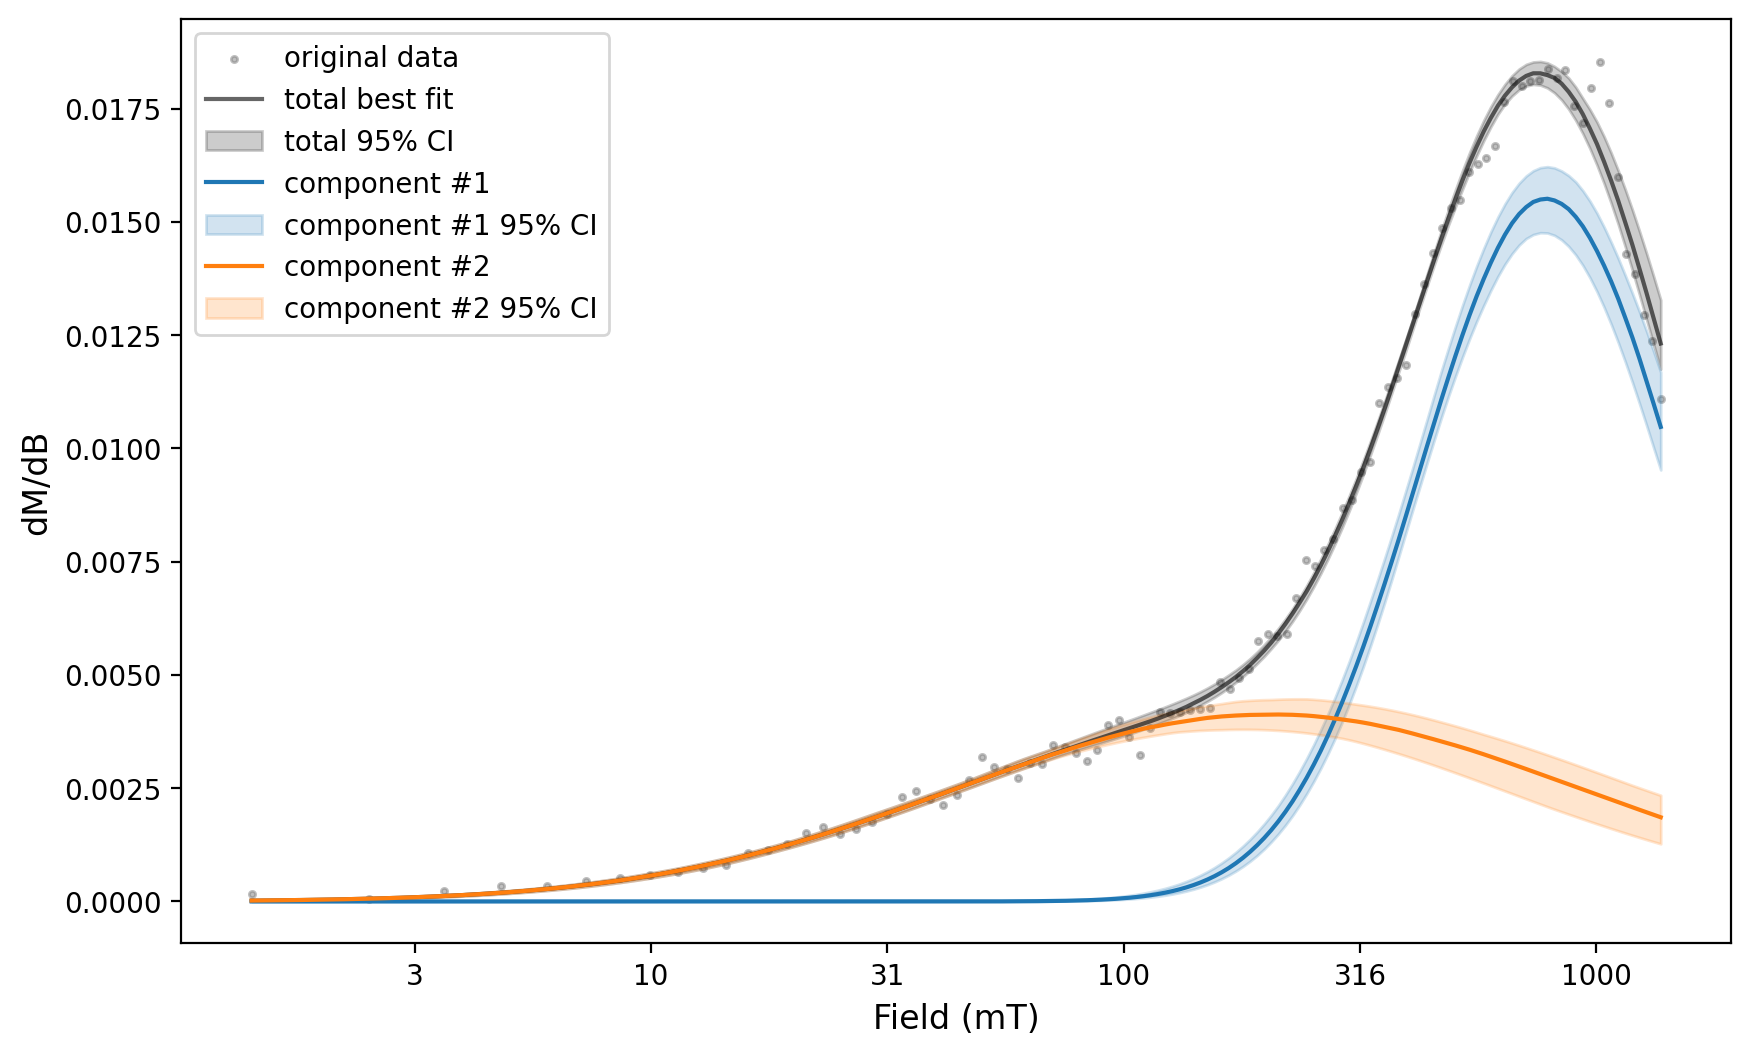

['BRIC-31c']


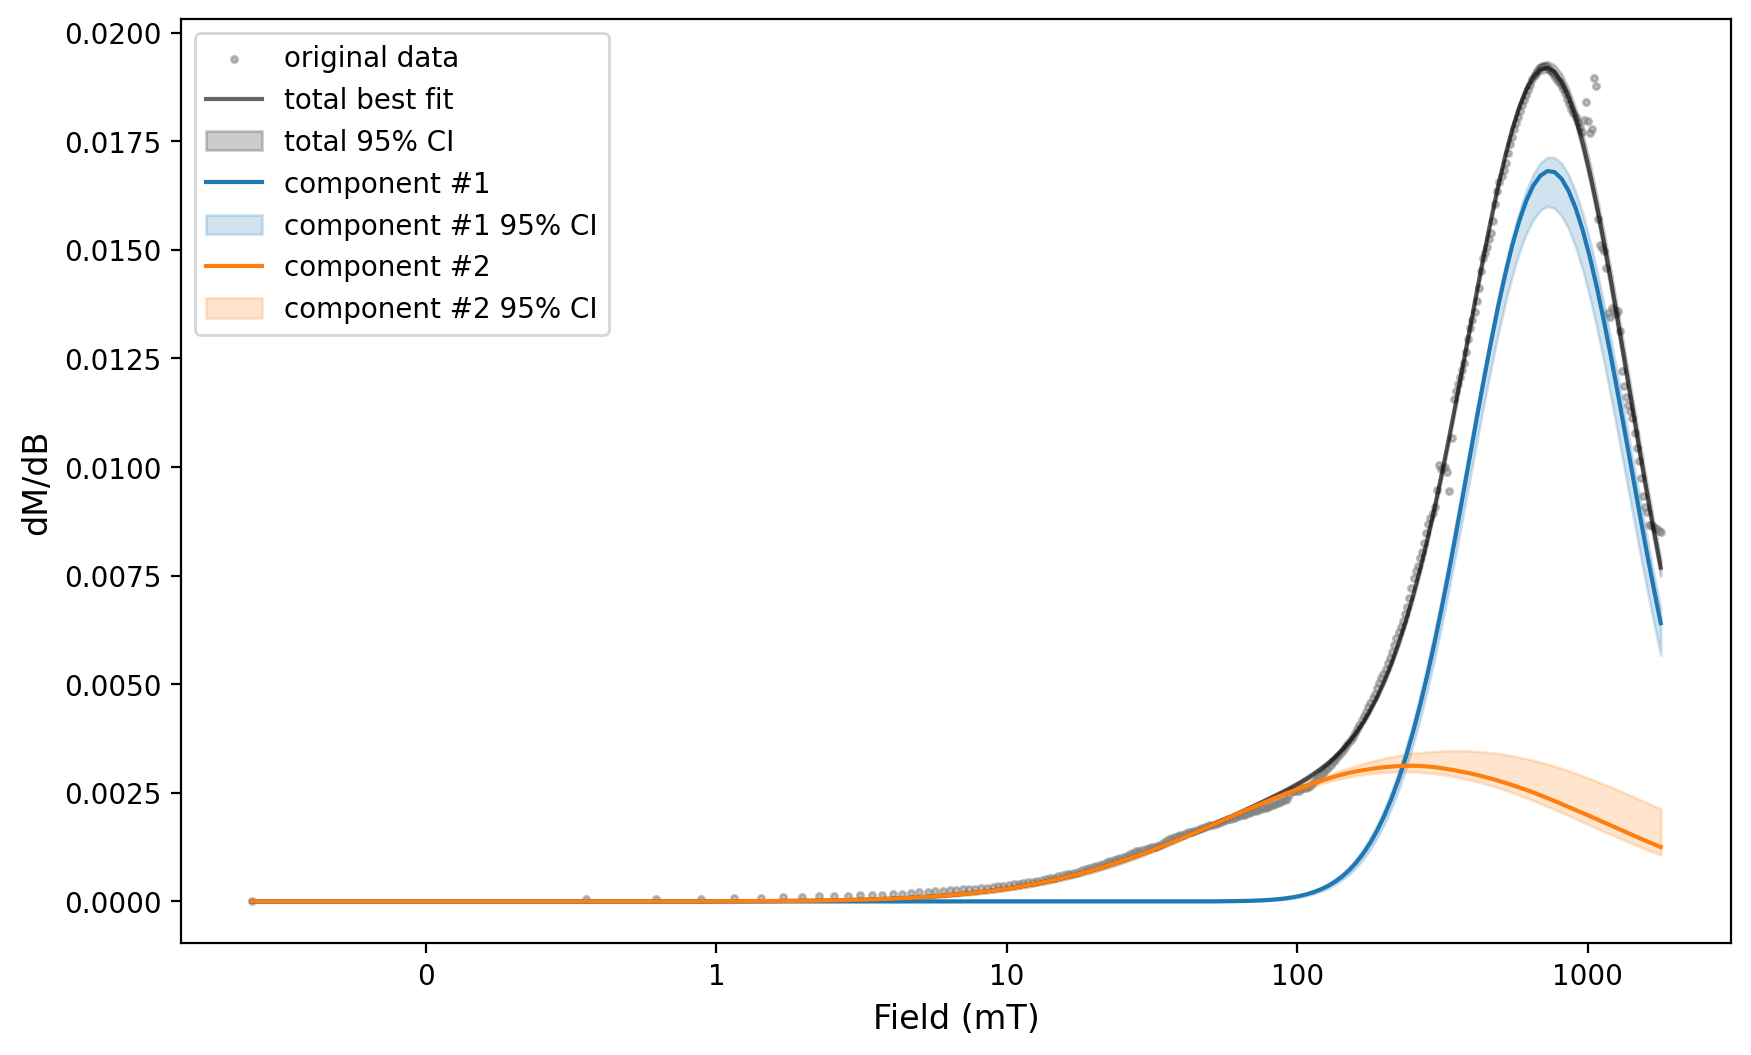

['BRIC.22c']


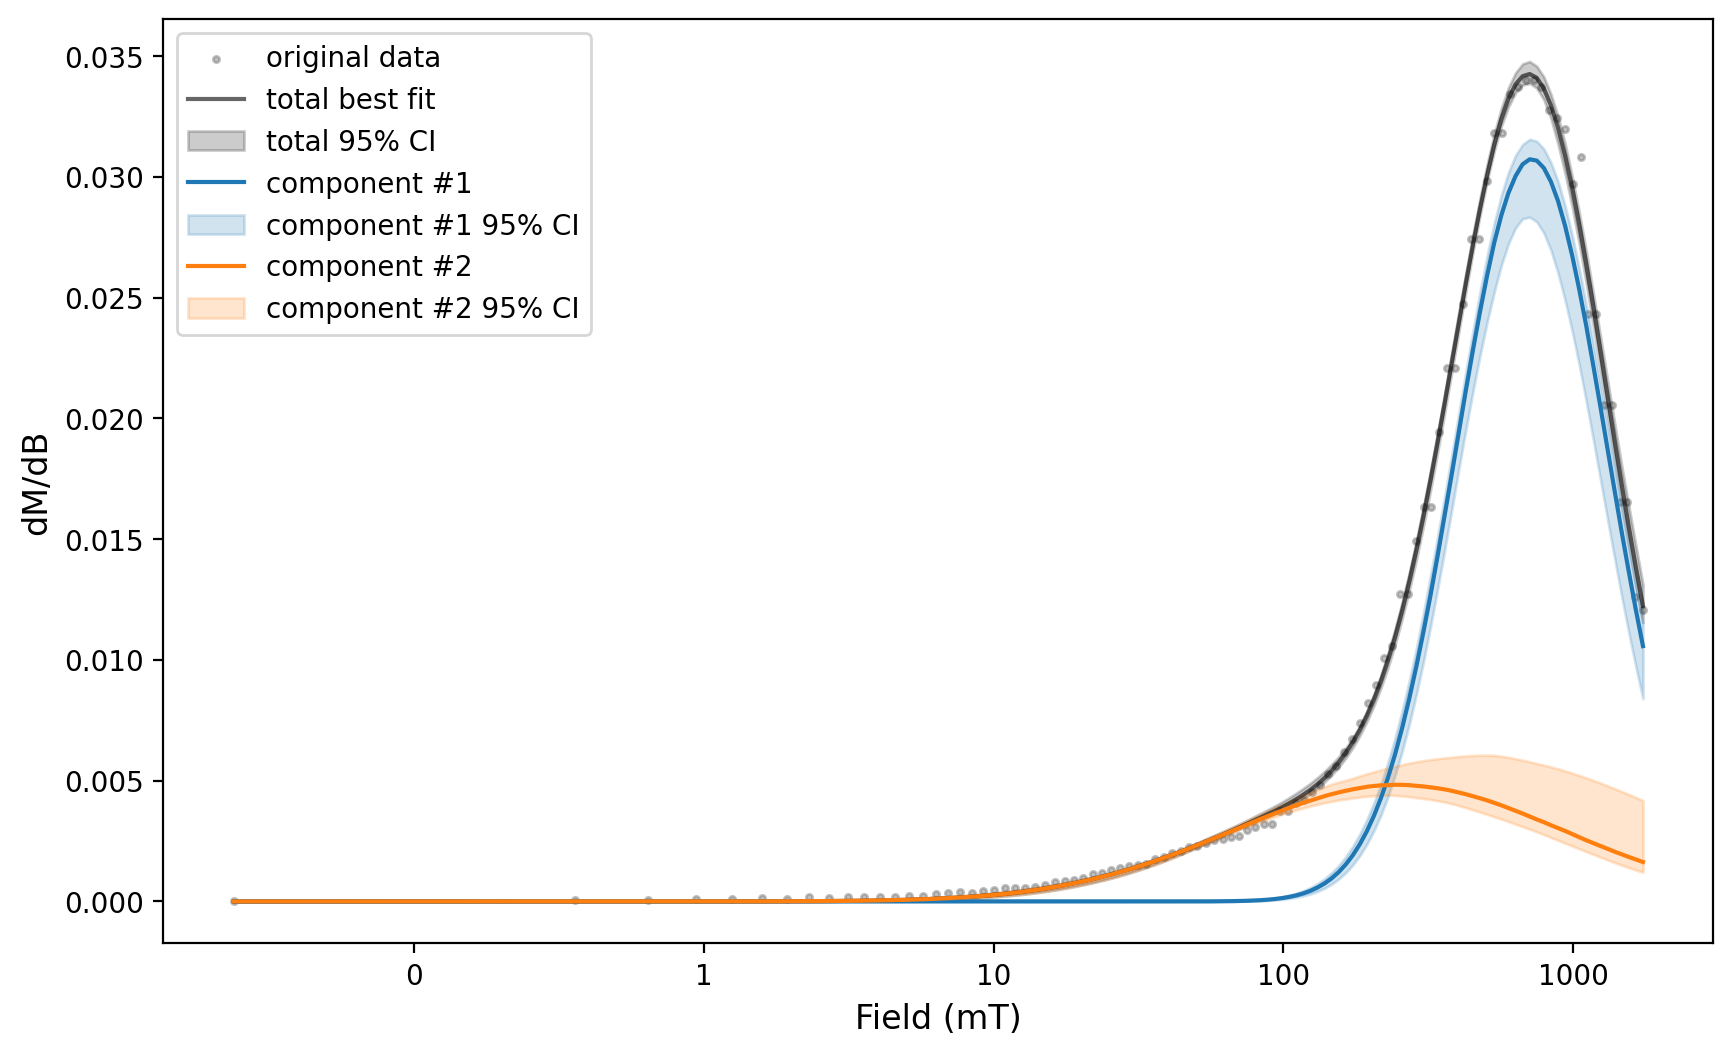

['BRIC.26c']


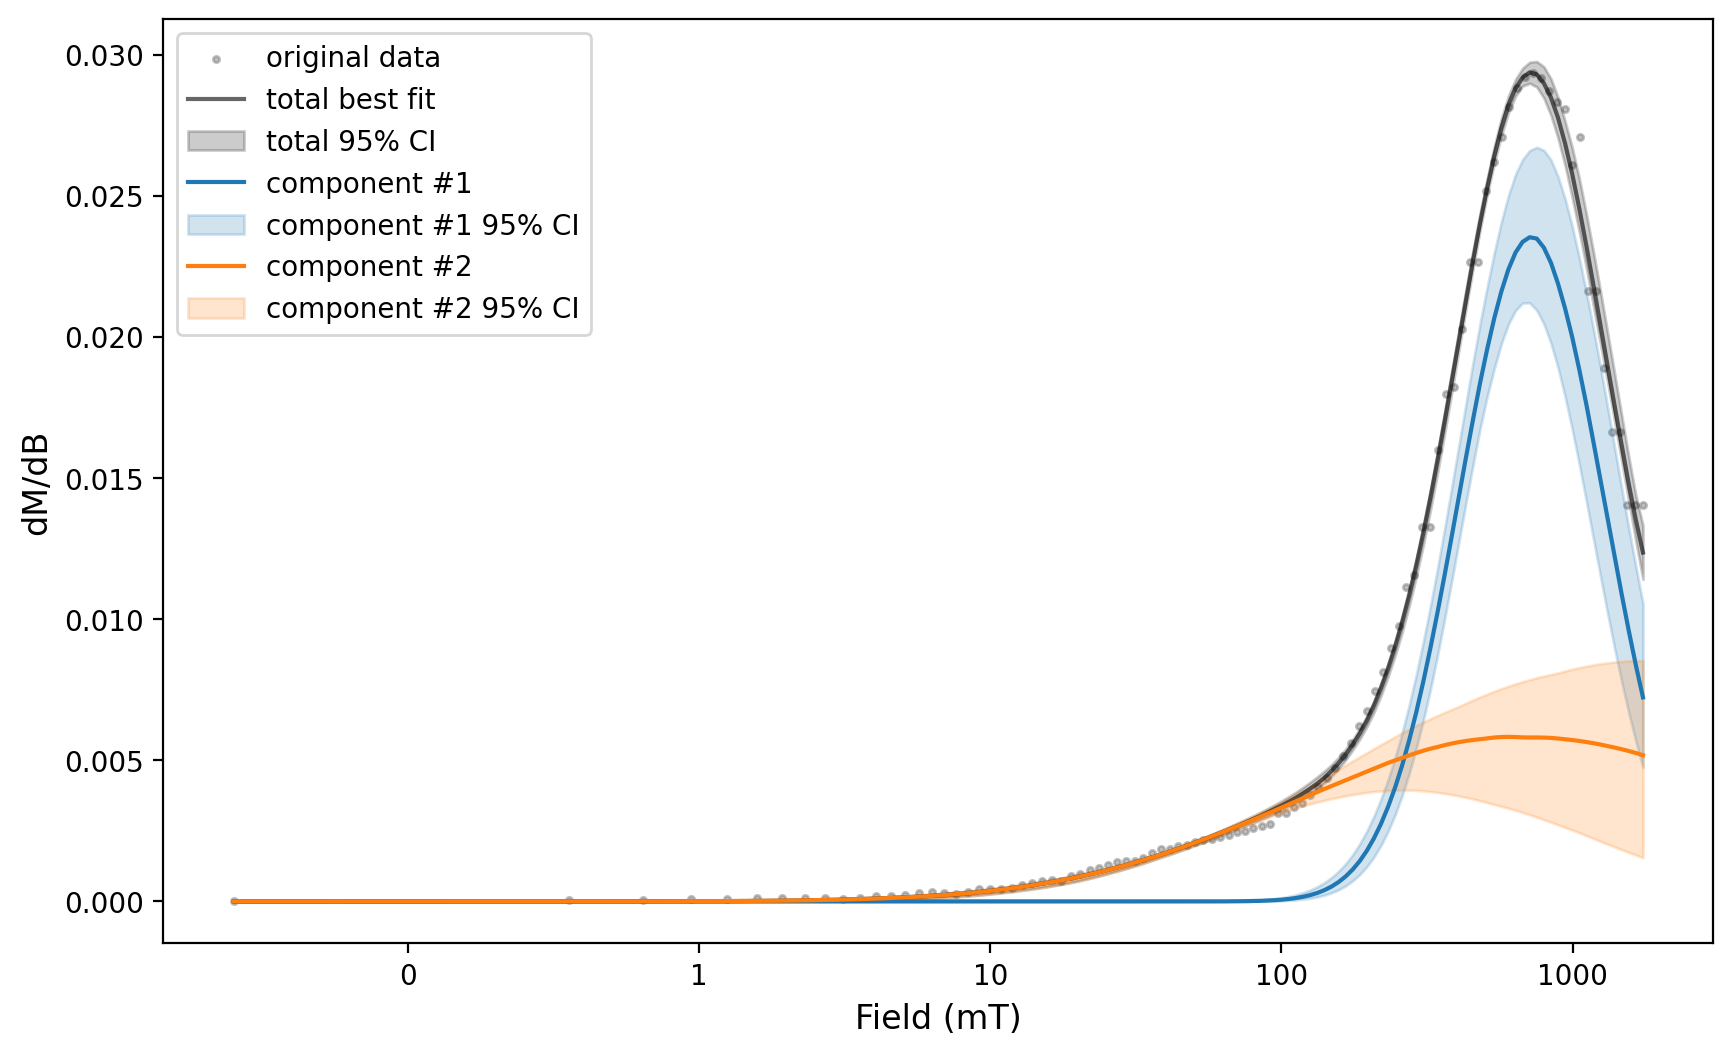

In [19]:
params_by_experiment = {}

for ex in [backfield_experiments[i] for i in [0, 2, 12, 14, 15]]:
    backfield_experiment = measurements_backfield[measurements_backfield['experiment'] == ex]
    print(backfield_experiment['specimen'].unique())
    experiment, Bcr = rmag.backfield_data_processing(backfield_experiment, 
                                                          field='treat_dc_field', magnetization='magn_mass', 
                                                          smooth_frac=0.05)
    experiment_ax, experiment_params = rmag.backfield_MaxUnmix(experiment['smoothed_log_dc_field'], 
                                                            experiment['smoothed_magn_mass_shift'], 
                                                            n_comps=2, parameters=two_fits, n_resample=100, skewed=False,)
    fig = experiment_ax.get_figure()
    plt.show(fig)